In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
books = pd.read_csv("../flatfiles/all_books.csv", parse_dates=["finished", "started"])

all_books = books.copy()
books = books[books["finished"].dt.year >= 2015]

books["year_read"] = books["finished"].dt.year
books["month_read"] = books["finished"].dt.month_name()

books["days_to_finish"] = (books["finished"] - books["started"]).dt.days

In [4]:
all_books["finished"].isna().any()

True

In [3]:
books["finished"].isna().any()

False

In [5]:
def make_timeline():
    month_order = [
        "January", "February", "March",
        "April", "May", "June",
        "July", "August", "September",
        "October", "November", "December"
    ]
    time_order = []
    for year in ["2015", "2016", "2017", "2018", "2019", "2020", "2021"]:
        for month in month_order:
            time_order.append(month + " " + year)
    return time_order

In [6]:
def add_timeline(df):
    timeline = make_timeline()
    df_timeline = df.copy()
    missing = ["August 2019", "September 2019", "November 2019", "November 2017"]
    
    keys = df_timeline["month_read"] + " " + df_timeline["year_read"].astype("str")
    
    df_timeline["timeline"] = pd.Categorical(
        keys,
        [key for key in timeline if key in np.append(keys.values, missing)],
        ordered=True
    )
    return df_timeline.sort_values(by="timeline")

In [7]:
def format_grouped_by_date(df, col, estimator):
    methods = {
        "count": pd.Series.count, 
        "mean": pd.Series.mean, 
        "max": pd.Series.max
    }
    return (
        add_timeline(df)[[col, "timeline"]]
        .groupby("timeline")[col]
        .apply(methods[estimator])
        .reset_index()
    )

In [59]:
def books_over_time(df, ax=None, show=False, pdf=None):
    books_over_time = format_grouped_by_date(df, "title", "count")
    timeline = books_over_time["timeline"]
    x_vals = [label if label.startswith("January") else "" for label in timeline]
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18,8))
    
    ax.plot(timeline, books_over_time["title"], marker="o")
    plt.xticks(range(len(x_vals)), x_vals, rotation=65, ha="right")
    plt.title("Number of Books Over Time")
    plt.xlabel("")
    plt.ylabel("Number of Books")
    plt.axhline(
        np.mean(books_over_time["title"]),
        label="Average books in a month: " + str(np.ceil(np.mean(books_over_time["title"]))),
        color="orange"
    )
    plt.axvline("October 2018", label="Move to Nor Cal", color="red", linestyle="--")
    plt.axvline("August 2020", label="Move to Missouri", color="orange", linestyle="--")
    plt.axvline("June 2017", label="Graduated From UCI", color="violet", linestyle="--")
    plt.legend(loc=3)
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

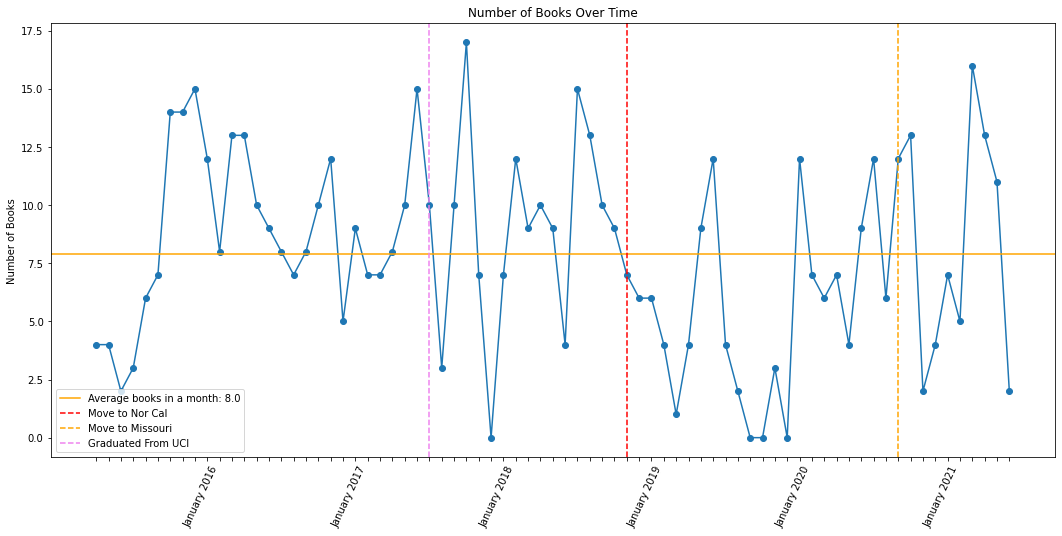

In [60]:
# plt.figure(figsize=(18, 8))
# ax = plt.subplot(122)
books_over_time(books,  show=True)

In [64]:
def pages_read_over_time(df, ax=None, show=False, pdf=None):
    pages_over_time = format_grouped_by_date(books, "pages", "mean")
    timeline = pages_over_time["timeline"]
    x_vals = [label if label.startswith("January") else "" for label in timeline]
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18,8))
    ax.plot(timeline, pages_over_time["pages"], marker="o")
    plt.axis([-3, len(x_vals)+3, 0, 700])
    plt.xticks(range(len(x_vals)), x_vals, rotation=65, ha="right")
    plt.title("Average Pages Over Time")
    plt.xlabel("")
    plt.ylabel("Average Number of Pages")
    plt.axhline(
        np.mean(pages_over_time["pages"]), 
        label="Average pages in a month: " + str(np.ceil(np.mean(pages_over_time["pages"]))), 
        color="orange"
    )

    plt.axvline("October 2018", label="Move to Northern California", color="red", linestyle="--")
    plt.axvline("August 2020", label="Move to Missouri", color="orange", linestyle="--")
    plt.axvline("June 2017", label="Graduated from UCI", color="violet", linestyle="--")
    plt.legend(loc=3)
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

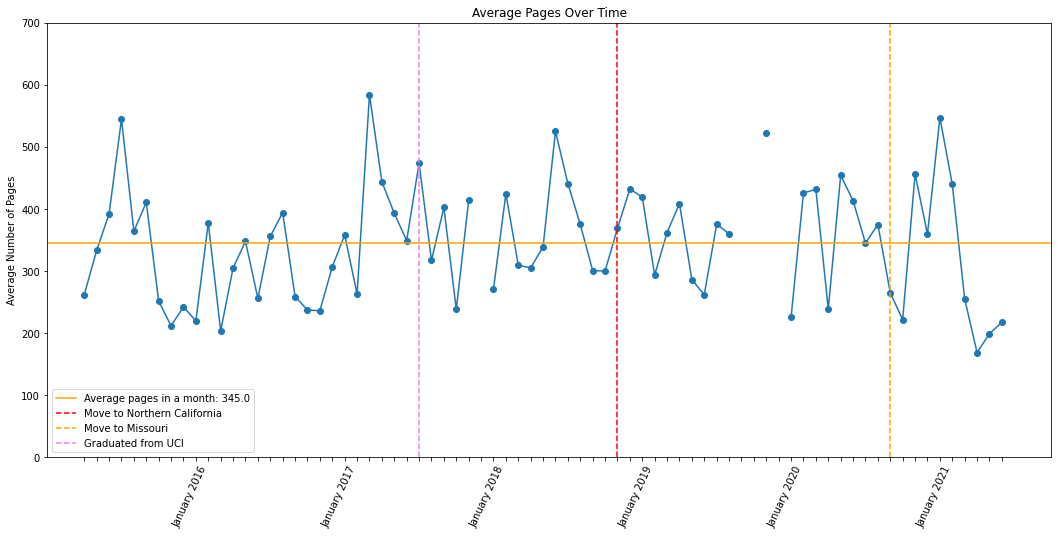

In [65]:
# ax = plt.subplot(111)
pages_read_over_time(books, show=True)

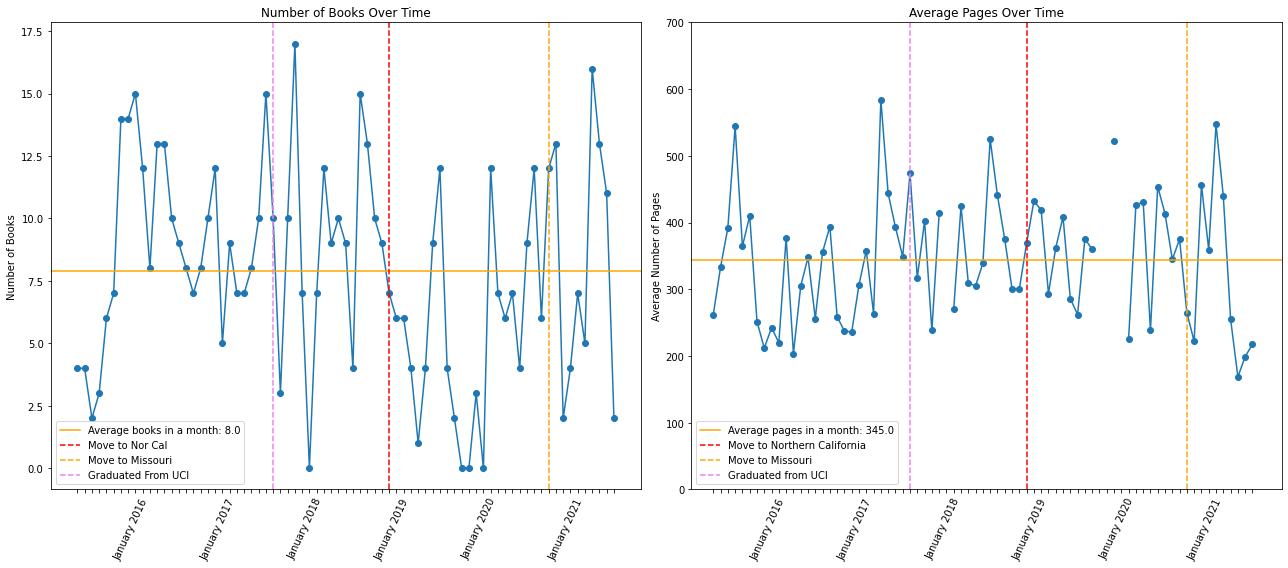

In [66]:
plt.figure(figsize=(18, 8))
ax1 = plt.subplot(121)
books_over_time(books, ax1)

ax2 = plt.subplot(122)
pages_read_over_time(books, ax2)
plt.tight_layout()
plt.show()

In [13]:
def book_length_hist(df, ax=None, show=False, pdf=None):
    page_counts = df[df["dnf"] != "x"]["pages"].dropna().copy()
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(18,8))
    ax.hist(page_counts, bins=30, alpha=0.7)
    
    plt.title("Book Lengths")
    plt.ylabel("Number of Books")
    plt.xlabel("Number of Pages")
    
    mean_pages = np.mean(page_counts)
    median_pages = np.median(page_counts)
    std_pages = np.std(page_counts)
    
    plt.axvline(mean_pages, color="orange", label=f"Average Number of Pages - {np.ceil(mean_pages)}")
    plt.axvline(median_pages, color="green", label=f"Median Page Count - {np.ceil(median_pages)}")
    plt.axvline(mean_pages + std_pages, linestyle="--", color="red", label=f"1 STD Away From Mean - {np.round(std_pages, 2)}")
    plt.axvline(mean_pages - std_pages, linestyle="--", color="red")
    plt.legend()
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

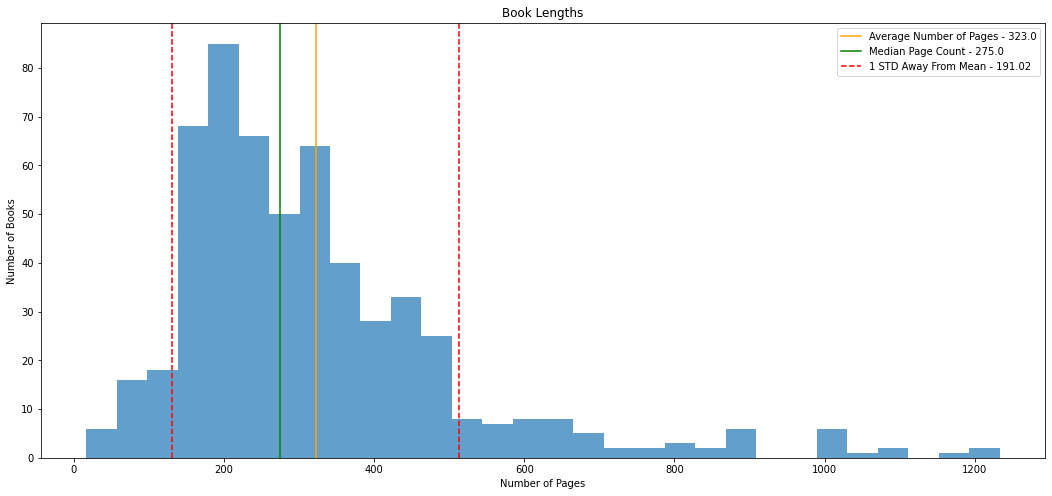

In [14]:
# plt.figure(figsize=(18, 8))
# ax = plt.subplot(121)
book_length_hist(books, show=True)

In [15]:
def make_seasons_table(df):
    spring = ["March", "April", "May"]
    summer = ["June", "July", "August"]
    fall = ["September", "October", "November"]
    winter = ["December", "January", "February"]

    book_seasons = df.copy()

    book_seasons.loc[book_seasons["finished"].dt.month_name().isin(spring), "season"] = "spring"
    book_seasons.loc[book_seasons["finished"].dt.month_name().isin(summer), "season"] = "summer"
    book_seasons.loc[book_seasons["finished"].dt.month_name().isin(fall), "season"] = "fall"
    book_seasons.loc[book_seasons["finished"].dt.month_name().isin(winter), "season"] = "winter"
    
    return book_seasons

In [16]:
def books_by_season(df, ax=None, show=False, pdf=None):
    book_seasons = make_seasons_table(df)[["title", "season"]]
    counts_by_season = book_seasons.groupby("season")["title"].count().reset_index()
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18,8))
    ax.bar(range(4), counts_by_season["title"])
    ax.set_xticks(range(4))
    ax.set_xticklabels(counts_by_season["season"])
    ax.set_title("Books By Season")
    ax.set_xlabel("")
    ax.set_ylabel("Number of Books")
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
    if show:
        plt.show()

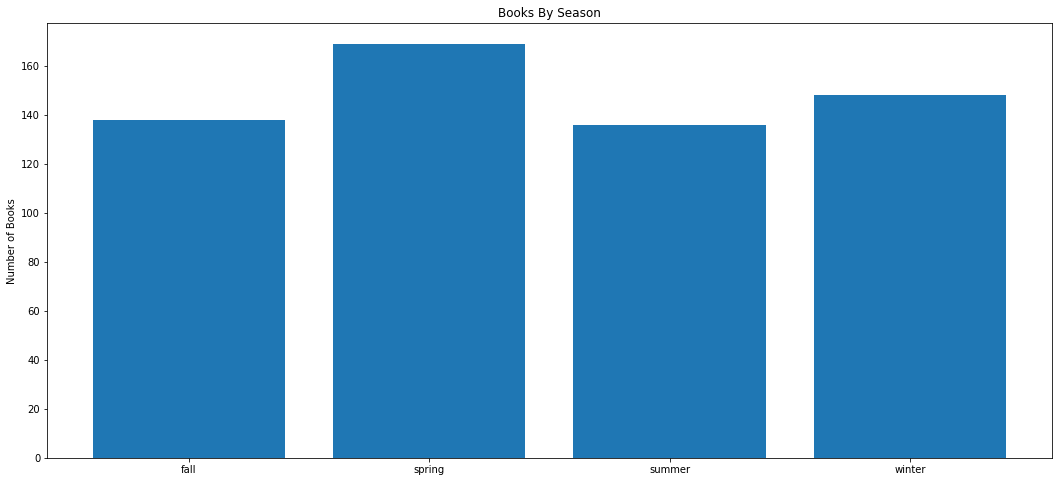

In [17]:
# plt.figure(figsize=(18,8))
books_by_season(books, show=True)

In [18]:
def pages_by_season(df, ax=None, show=False, pdf=None):
    book_seasons = make_seasons_table(books)[["pages", "season"]]
    pages_by_season = book_seasons.groupby("season")["pages"].mean().reset_index()
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18,8))
    ax.bar(range(4), pages_by_season["pages"])
    ax.set_xticks(range(4))
    ax.set_xticklabels(pages_by_season["season"], rotation=0)
    ax.set_title("Pages by Season")
    ax.set_xlabel("")
    ax.set_ylabel("Average Number of Pages")
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

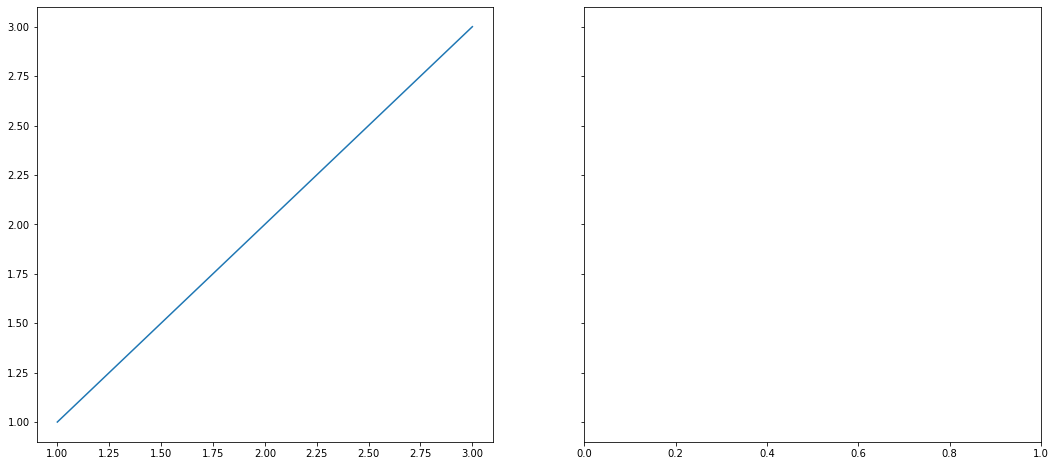

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(18,8), sharey=True)
ax[0].plot([1,2,3], [1,2,3])

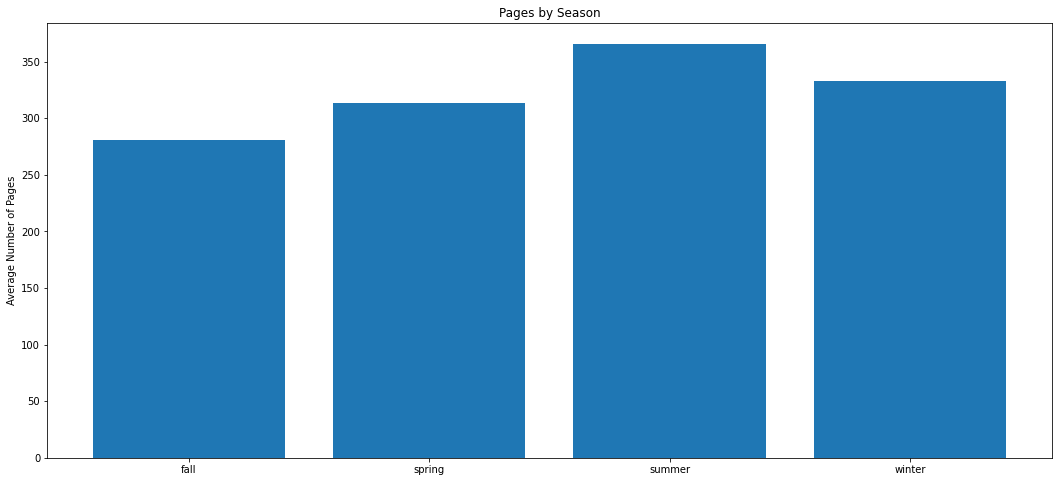

In [20]:
# plt.figure(figsize=(18, 8))
pages_by_season(books, show=True)

plt.close("all")

spring = ["March", "April", "May"]
summer = ["June", "July", "August"]
fall = ["September", "October", "November"]
winter = ["December", "January", "February"]

book_seasons = books[["title", "finished", "pages"]].copy()

book_seasons.loc[book_seasons["finished"].dt.month_name().isin(spring), "season"] = "spring"
book_seasons.loc[book_seasons["finished"].dt.month_name().isin(summer), "season"] = "summer"
book_seasons.loc[book_seasons["finished"].dt.month_name().isin(fall), "season"] = "fall"
book_seasons.loc[book_seasons["finished"].dt.month_name().isin(winter), "season"] = "winter"

counts_by_season = book_seasons.groupby("season")["title"].count().reset_index()
pages_by_season = book_seasons.groupby("season")["pages"].mean().reset_index()

ax2 = plt.subplot(1, 2, 2)
plt.bar(range(4), pages_by_season["pages"])
ax2.set_xticks(range(4))
ax2.set_xticklabels(pages_by_season["season"])
plt.title("Pages by Season")
plt.xlabel("Season")
plt.ylabel("Average Number of Pages")

plt.tight_layout()
# pdf_test.savefig()
plt.show()

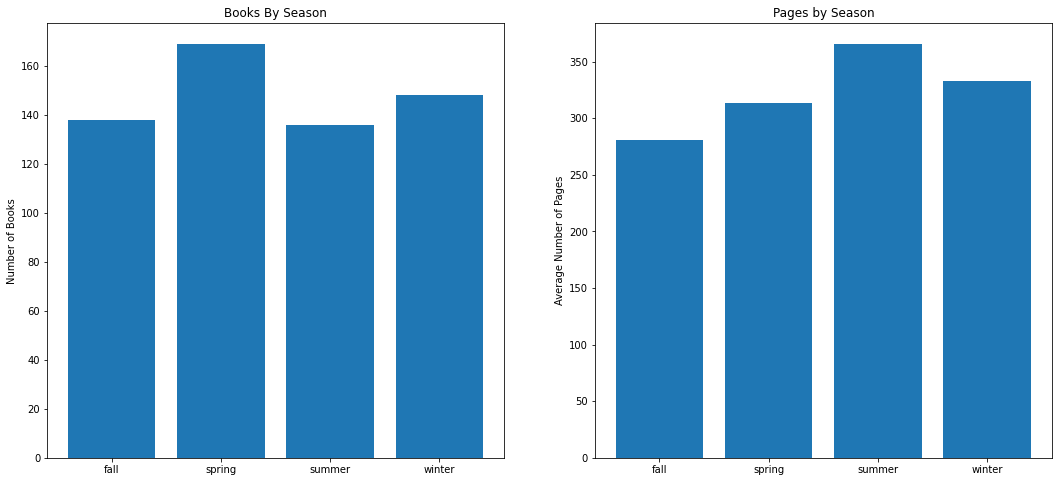

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(18,8))
books_by_season(books, ax=ax[0])
pages_by_season(books, ax=ax[1])
plt.show()

plt.clf()
plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
sns.boxplot(data=book_seasons, x="season", y="pages")
plt.subplot(1, 2, 2)
sns.barplot(data=counts_by_season, x="season", y="title")
plt.tight_layout()
plt.show()

In [22]:
def add_percent_f_nf(df):
    f_nf = (
        df[df["dnf"] != "x"]
        .copy()
        .groupby("f_nf")["title"]
        .count()
        .reset_index()
    )
    f_nf["pcts"] = f_nf["title"] / f_nf["title"].sum()
    return f_nf
    

In [23]:
test = add_percent_f_nf(books)

In [24]:
def fiction_vs_nonfiction(df, ax=None, show=False, pdf=None):
    f_nf = add_percent_f_nf(df)
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18,8))
    ax.pie(f_nf["pcts"], autopct="%0.1f%%", pctdistance=1.15, startangle=270, explode=[0.05,0])
    ax.pie(f_nf["pcts"], radius=0.8, colors=["white", "white"], explode=[0.05, 0], startangle=270, wedgeprops={"edgecolor": "white"})
    ax.axis("equal")
    ax.legend(f_nf["f_nf"])
    ax.set_title("Fiction / Nonfiction Proportions")
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

In [25]:
test

,f_nf,title,pcts
0,f,355,0.600677
1,nf,236,0.399323


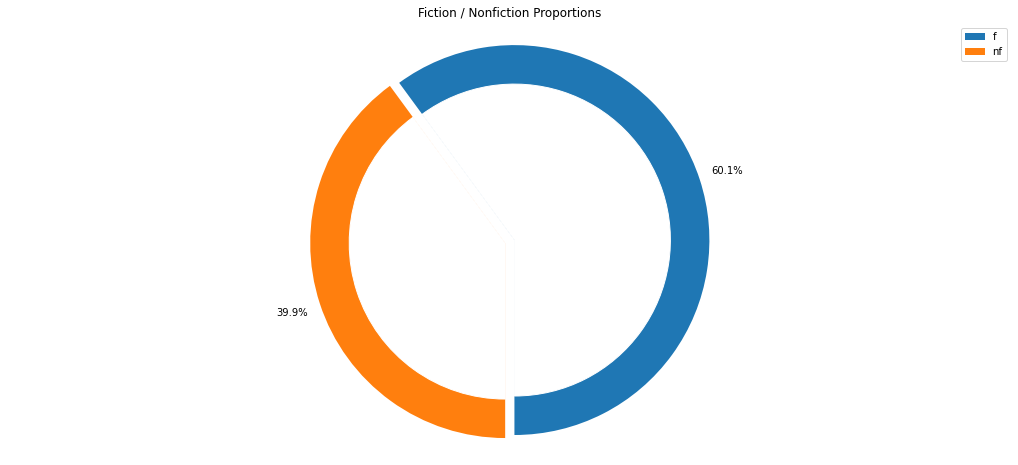

In [26]:
fiction_vs_nonfiction(books, show=True)

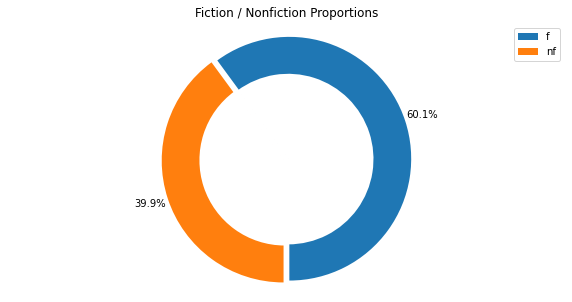

In [27]:
plt.close("all")

f_nf = books[(books["dnf"] != "x")][["title", "f_nf"]].copy()
f_nf = f_nf.groupby("f_nf")["title"].count().reset_index()
f_nf["pcts"] = f_nf["title"].div(f_nf["title"].sum())

plt.figure(figsize=(10, 5))
ax = plt.subplot()
plt.pie(f_nf["pcts"], autopct="%0.1f%%", pctdistance=1.15, startangle=270, explode=[0.05, 0])
plt.pie(f_nf["pcts"], radius=0.7, colors=["white", "white"], explode=[0.04, -0.01], startangle=270)
plt.axis("equal")
plt.legend(f_nf["f_nf"])

plt.title("Fiction / Nonfiction Proportions")
# pdf_test.savefig()
plt.show()

In [28]:
def add_pct_of_rating(df):
    ratings = (
        df[["title", "rating"]]
        .copy()
        .dropna()
        .groupby("rating")["title"]
        .count()
        .reset_index()
    )
    ratings["pct_of_total"] = ratings["title"] / ratings["title"].sum()
    return ratings

In [29]:
def rating_spread(df, ax=None, show=False, pdf=None):
    ratings = add_pct_of_rating(df)
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18,8))
    percents = ratings["pct_of_total"]
    explode = [0, 0, 0, 0, 0.1, 0.1]
    ax.pie(percents, autopct="%0.1f%%", pctdistance=1.10, explode=explode)
    ax.pie(percents, colors=["white"]*len(percents), radius=0.7, center=(0,0), explode=explode, wedgeprops={"edgecolor": "white"})
    ax.legend(ratings["rating"])
    ax.set_title("Proportion of Ratings") # Using these instead of plt.title so that it stays with the axis in custom configs
    ax.axis("equal")
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

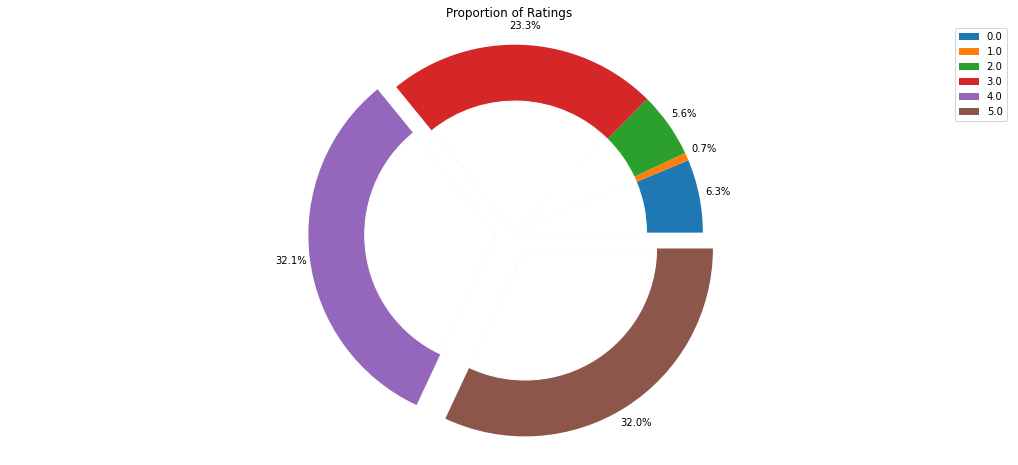

In [30]:
rating_spread(books, show=True)

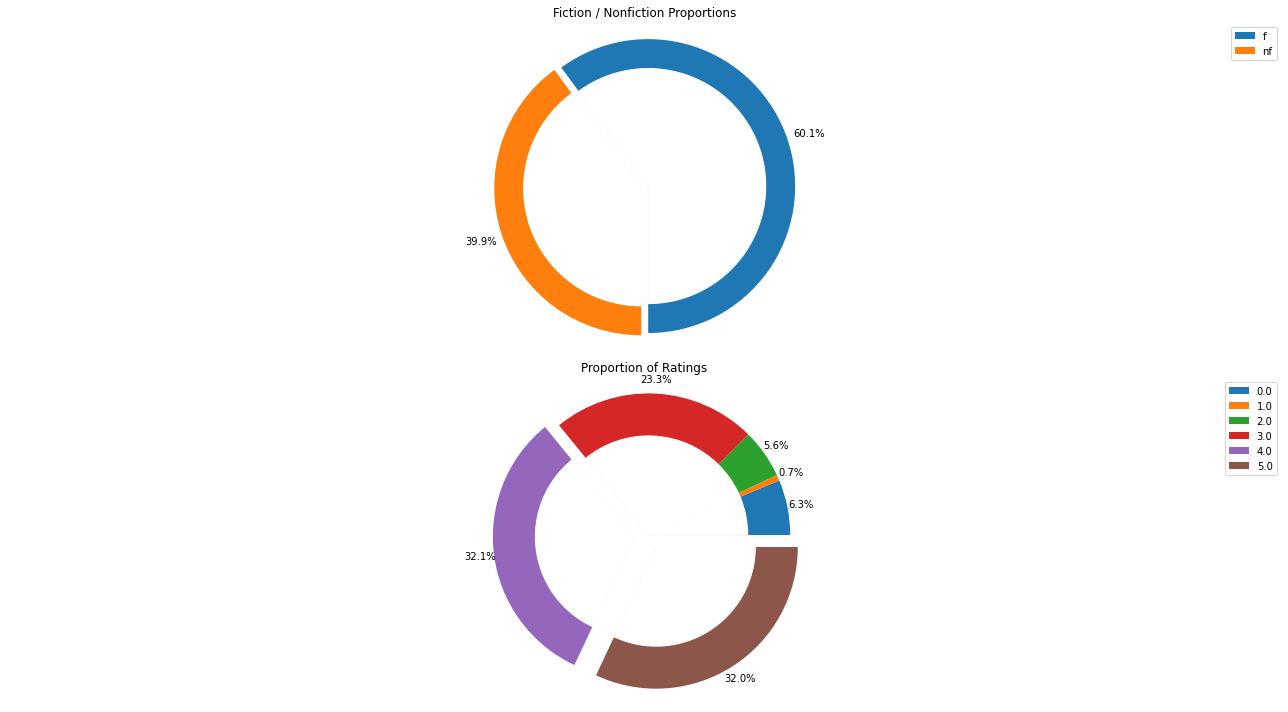

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(18,10))
fiction_vs_nonfiction(books, ax=axs[0])
rating_spread(books, ax=axs[1])
plt.tight_layout()
plt.show()

In [32]:
def group_by_genre(df):
    return (
        df
        .copy()
        .dropna(subset=["genre"])
        .groupby("genre")["title"]
        .count()
        .reset_index()
        .sort_values(
            by="title",
            ascending=False
        )
    )

In [33]:
def books_by_genre(df, ax=None, show=False, pdf=None):
    books_by_genre = group_by_genre(df)
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(18, 8))
    x_vals = range(len(books_by_genre["genre"]))
    ax.bar(x_vals, books_by_genre["title"])
    ax.set_xticks(x_vals)
    ax.set_xticklabels(books_by_genre["genre"],rotation=75)
    ax.set_title("Books by Genre")
    ax.set_xlabel("")
    ax.set_ylabel("Number of Books")
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

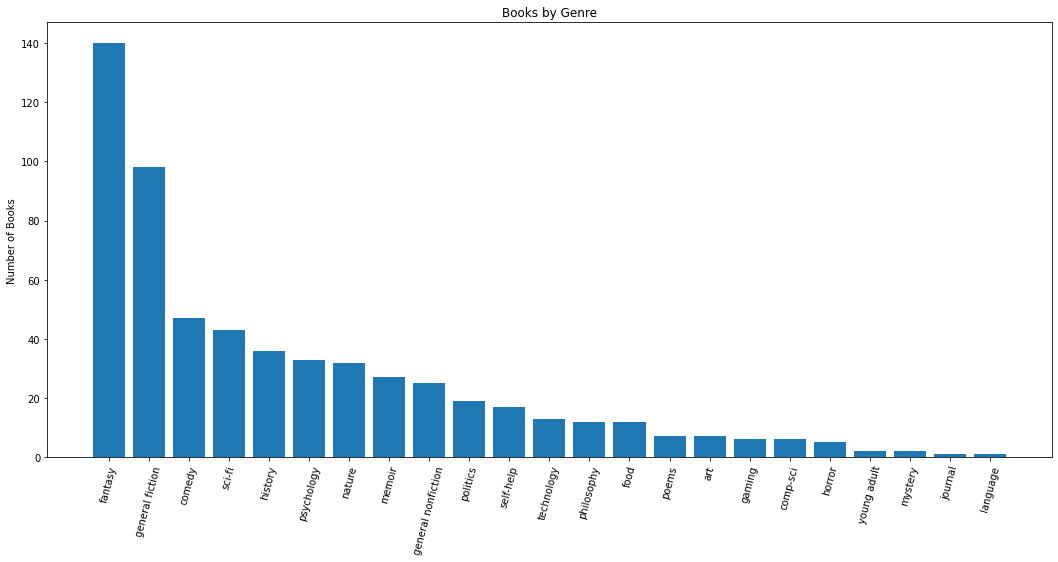

In [34]:
books_by_genre(books, show=True)

plt.close("all")

books_by_genre = books[~(books["finished"].isna())][["title", "genre"]].copy().dropna()
books_by_genre = books_by_genre.groupby("genre")["title"].count().reset_index().sort_values(by="title", ascending=False)

plt.figure(figsize=(10, 6))
ax = plt.subplot()

plt.bar(range(len(books_by_genre["genre"])), books_by_genre["title"])

ax.set_xticks(range(len(books_by_genre["genre"])))
ax.set_xticklabels(books_by_genre["genre"], rotation=75)

plt.title("Books by Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Books")
plt.show()

plt.close("all")

ratings = books[["title", "rating"]].copy().dropna()

ratings = ratings.groupby("rating")["title"].count().reset_index()
# ratings["pct_of_total"] = ratings["title"].apply(lambda x: x / ratings["title"].sum())
ratings["pct_of_total"] = ratings["title"].div(ratings["title"].sum())
plt.figure(figsize=(10, 5))
plt.axis("equal")
plt.pie(ratings["pct_of_total"], autopct="%0.1f%%", pctdistance=1.15, explode=[0, 0, 0, 0, 0.1, 0.1])
plt.pie(ratings["pct_of_total"], explode=[x-0.01 for x in [0, 0, 0, 0, 0.1, 0.1]], radius=0.7, colors=["white"]*len(ratings["pct_of_total"]))
plt.legend(ratings["rating"])
plt.title("Proportion of Ratings")
# pdf_test.savefig()
plt.show()

In [35]:
def get_books_read_in_pub_year(df, year):
    return df[
        (df["finished"].dt.year == year)
        & (df["year"] == year)
    ].copy()

def get_y_vals_by_year(df, year_list):
    return [
        len(get_books_read_in_pub_year(df, year)) / len(df[df["finished"].dt.year == year])
        for year in year_list
    ]

def get_totals(df, year_list):
    return [
        len(df[df["finished"].dt.year == year])
        for year in year_list
    ]

In [36]:
x_values = ["2016", "2017", "2018", "2019", "2020"]
list(map(int, x_values))

[2016, 2017, 2018, 2019, 2020]

In [37]:
def top_bars(ax, y_vals):
    ax.bar(range(6), [1-y_val for y_val in y_vals], bottom=y_vals, label="Backlog")

In [38]:
def current_releases(df, ax=None, show=False, pdf=None):
    x_vals = ["2016", "2017", "2018", "2019", "2020", "2021"]
    year_list = list(map(int, x_vals))
    y_vals = get_y_vals_by_year(df, year_list)
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(18, 8))
    
    ax.bar(range(6), y_vals, label="Read in Year Pubbed")
    
    for idx, value in enumerate(y_vals):
        ax.text(
            idx, 
            value+0.025, 
            str(round(value, 2)*100) + "%",
            horizontalalignment="center", 
            fontweight="bold", 
            fontsize=14
        )
    totals = get_totals(df, year_list)
    for idx, value in enumerate(totals):
        ax.text(idx, 0.8, "Total\nBooks:\n"+ str(value), horizontalalignment="center", fontweight="bold")
    top_bars(ax, y_vals)
    ax.set_xticks(range(6))
    ax.set_xticklabels(x_vals)
    ax.set_title("Books Read in Year of Publication")
    ax.set_ylabel("Proportion of Books")
    ax.set_xlabel("")
    ax.legend()
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

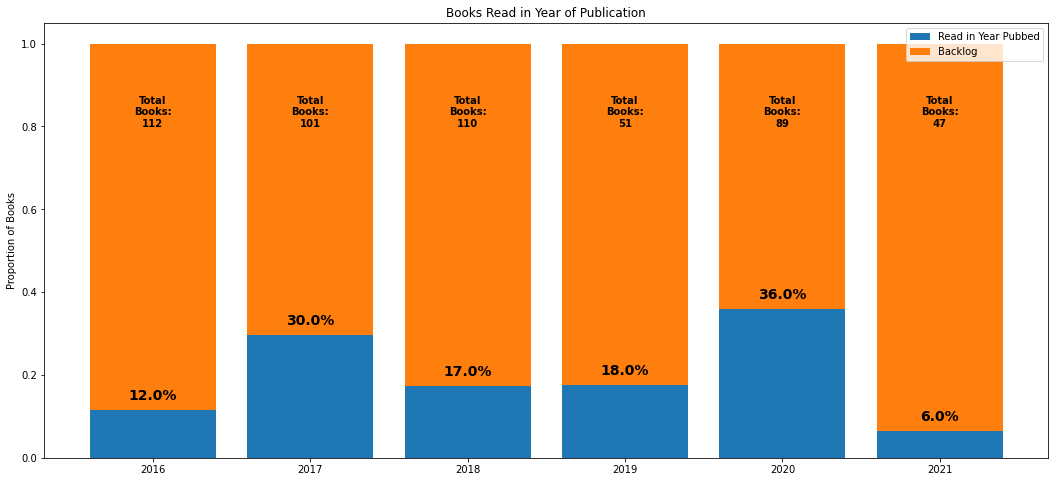

In [39]:
current_releases(books, show=True)

In [40]:
def books_by_year(df, ax=None, show=False, pdf=None):
    x_values = ["2016", "2017", "2018", "2019", "2020", "2021"]
    year_list = list(map(int, x_values))
    totals = get_totals(df, year_list)
    mean_totals = np.mean(totals)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(18, 8))
    ax.bar(range(6), totals)
    ax.set_xticks(range(6))
    ax.set_xticklabels(x_values)
    plt.axhline(mean_totals, label=f"Avg Per Year - {mean_totals}")
    ax.set_title("Totals Per Year")
    ax.set_ylabel("Number of Books")
    ax.set_xlabel("")
    ax.legend()
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

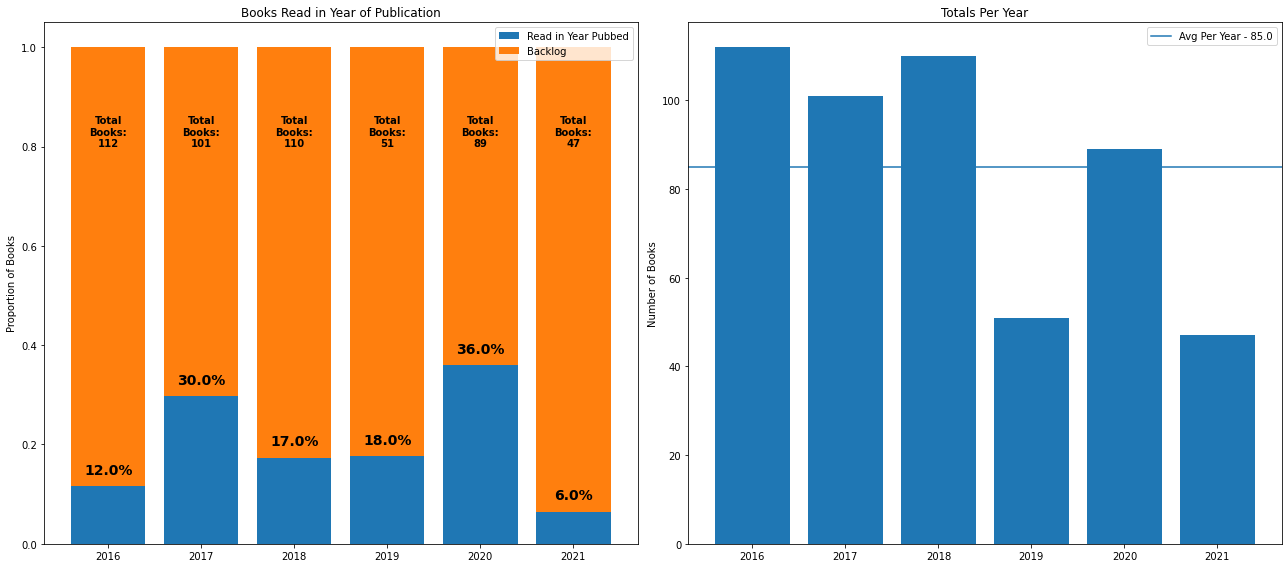

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(18, 8))
current_releases(books, ax=axs[0])
books_by_year(books, ax=axs[1])
plt.tight_layout()
plt.show()

In [42]:
def group_by_format(df):
    return (
        df[~df["finished"].isna()]
        .copy()
        .groupby("format")["title"]
        .count()
        .reset_index()
        .sort_values(by="title", ascending=False)
    )

In [43]:
def books_by_format(df, ax=None, show=False, pdf=None):
    books_by_format = group_by_format(df)
    x_vals = books_by_format["format"]
    y_vals = books_by_format["title"]
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(18, 8))
    ax.bar(range(len(x_vals)), y_vals)
    ax.set_xticks(range(len(x_vals)))
    ax.set_xticklabels(x_vals)
    ax.set_title("Book by Format")
    plt.xlabel("")
    plt.ylabel("Number of Books")
    
    if pdf:
        pdf.savefig(bbox_inches="tight")
        plt.close("all")
    if show:
        plt.show()

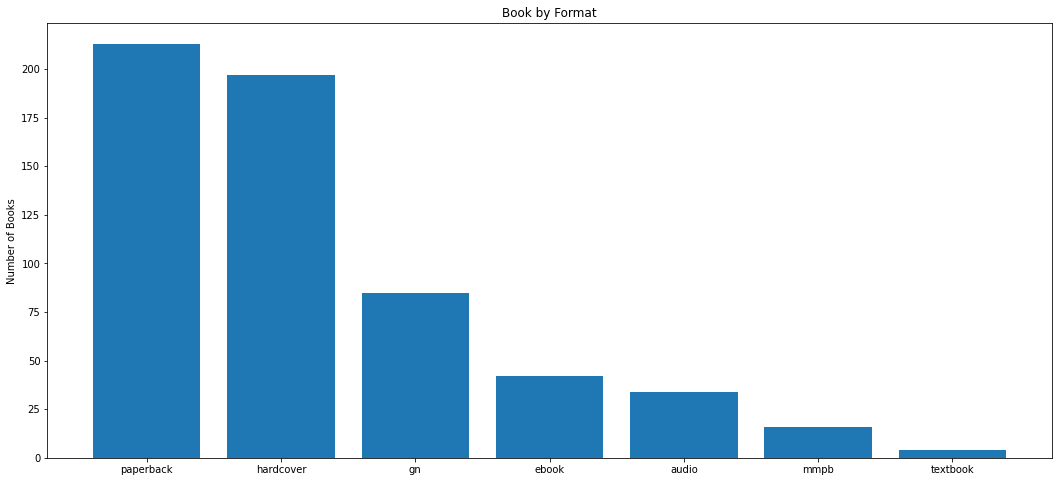

In [44]:
books_by_format(books, show=True)

In [45]:
def reading_speed_kde(df):
    squared_df = df.copy()
    plt.close("all")
    plt.figure(figsize=(12, 8))
    sns.kdeplot(data=squared_df, x="days_to_finish", shade=True)
    mean_days = np.mean(df["days_to_finish"])
    median_days = np.median(df[["days_to_finish"]].dropna()["days_to_finish"])
    mode_days, mode_counts = stats.mode(df[["days_to_finish"]].dropna()["days_to_finish"])
    std_days = np.std(df["days_to_finish"])
    plt.axvline(mean_days, label=f"Mean Days to Finish a Book - {np.round(mean_days, 1)}", color="red", linestyle="--")
    plt.axvline(median_days, label=f"Median Days to Finish a Book - {median_days}", color="green", linestyle="--")
    plt.axvline(mode_days, label=f"Mode Days to Finish a Book - {mode_days[0]}", color="violet", linestyle="--")
    plt.axvline(mean_days + std_days, label="1 std away", color="orange", linestyle="--")
    plt.xlim([0, int(df["days_to_finish"].max())+10])
    plt.legend()
#     pdf_test.savefig()
    plt.show()

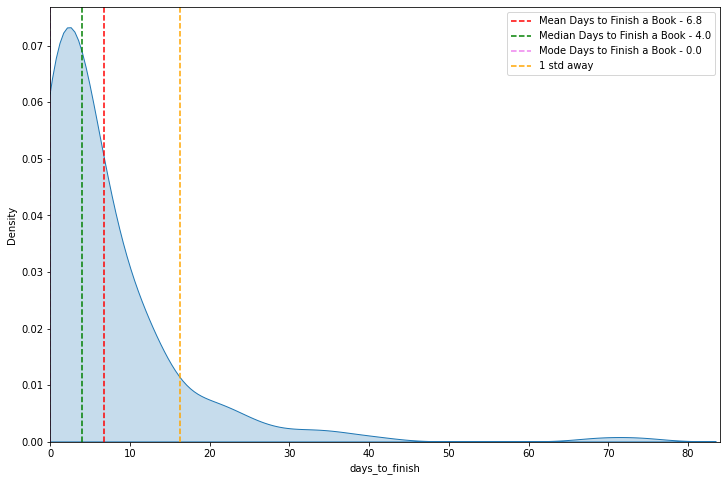

In [46]:
reading_speed_kde(books)

plt.close("all")
plt.figure(figsize=(18, 200))
ax = plt.subplot()
ax.axis("off")
ax.axis("tight")
ax.table(cellText=books.values, colLabels=books.columns, bbox=[0,0,1,1])
pdf_test.savefig()

In [47]:
# pdf_test.close()

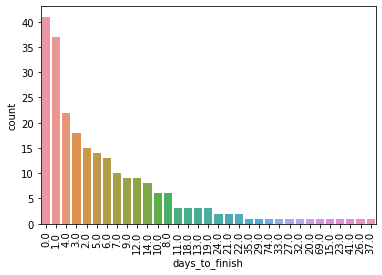

In [48]:
plt.close("all")
sns.countplot(x=books["days_to_finish"], order=books["days_to_finish"].value_counts().index)
plt.xticks(rotation=90)
plt.show()

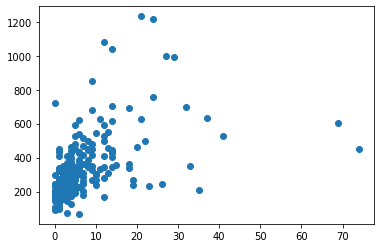

In [49]:
plt.close("all")
plt.scatter(x=books["days_to_finish"], y=books["pages"])
plt.show()

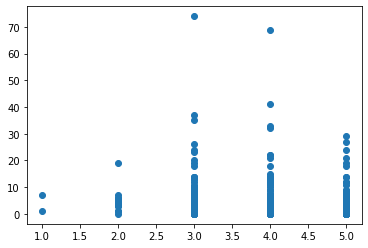

In [50]:
plt.close("all")
plt.scatter(x=books["rating"], y=books["days_to_finish"])
plt.show()

In [51]:
books.describe()

,year,pages,duration,rating,price,year_read,days_to_finish
count,591.000000,562.000000,29.000000,588.000000,111.000000,591.000000,239.000000
mean,1998.346870,322.325623,512.724138,3.702381,15.067297,2017.664975,6.753138
std,99.813113,191.187253,218.286492,1.326519,11.833581,1.860228,9.515232
min,180.000000,17.000000,119.000000,0.000000,0.000000,2015.000000,0.000000
25%,2005.500000,195.000000,396.000000,3.000000,7.820000,2016.000000,1.000000
50%,2013.000000,274.500000,463.000000,4.000000,14.990000,2018.000000,4.000000
75%,2017.000000,388.750000,625.000000,5.000000,19.355000,2019.000000,9.000000
max,2021.000000,1233.000000,1115.000000,5.000000,58.160000,2021.000000,74.000000


# Challenge: Find Associations Between Different Categorical Variables

In [52]:
books.head()

,title,author,started,finished,imprint,publishing_house,year,pages,duration,format,...,f_nf,price,genre,narrator,illustrator,translator,notes,year_read,month_read,days_to_finish
0,Uzumaki,Junji Ito,NaT,2017-05-17,Viz Media,Viz Media,2000.0,656.0,NaN,hardcover,...,f,NaN,horror,NaN,NaN,NaN,NaN,2017,May,NaN
1,The Shallows: What the Internet Is Doing to Ou...,Nicholas Carr,NaT,2017-10-01,Norton,W. W. Norton,2010.0,280.0,NaN,paperback,...,nf,NaN,technology,NaN,NaN,NaN,NaN,2017,October,NaN
2,The Sixth Extinction: An Unnatural History,Elizabeth Kolbert,NaT,2015-03-06,Henry Holt,Macmillan,2014.0,336.0,NaN,hardcover,...,nf,NaN,nature,NaN,NaN,NaN,NaN,2015,March,NaN
3,The Name of the Wind (The Kingkiller Chronicle...,Patrick Rothfuss,NaT,2017-02-28,DAW,Penguin Random House,2007.0,662.0,NaN,hardcover,...,f,NaN,fantasy,NaN,NaN,NaN,NaN,2017,February,NaN
4,"The Wise Man's Fear (The Kingkiller Chronicle,...",Patrick Rothfuss,NaT,2017-03-13,DAW,Penguin Random House,2011.0,994.0,NaN,hardcover,...,f,NaN,fantasy,NaN,NaN,NaN,NaN,2017,March,NaN


In [53]:
pd.crosstab(books["f_nf"], books["year"])

year,180.0,650.0,1593.0,1608.0,1729.0,1832.0,1848.0,1849.0,1861.0,1866.0,...,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0
f_nf,,,,,,,,,,,,,,,,,,,,,
f,0,1,1,1,0,1,0,0,1,1,...,16,12,24,13,24,35,18,23,29,3
nf,1,0,0,0,1,0,1,1,0,0,...,9,10,17,15,14,36,18,10,15,0


In [54]:
books["genre"].value_counts()

fantasy               140
general fiction        98
comedy                 47
sci-fi                 43
history                36
psychology             33
nature                 32
memoir                 27
general nonfiction     25
politics               19
self-help              17
technology             13
philosophy             12
food                   12
poems                   7
art                     7
gaming                  6
comp-sci                6
horror                  5
young adult             2
mystery                 2
language                1
journal                 1
Name: genre, dtype: int64

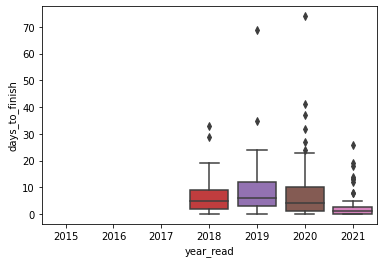

In [55]:
def reading_speed(df):
    sns.boxplot(data=df, x="year_read", y="days_to_finish")
    plt.show()
reading_speed(books)


ax = plt.subplot(111)

sub_df = books[["title", "author", "finished"]]
ax.axis("off")
ax.axis("tight")

ax.table(cellText=sub_df.values, colLabels=sub_df.columns, loc="center")
plt.show()

In [56]:
books

,title,author,started,finished,imprint,publishing_house,year,pages,duration,format,...,f_nf,price,genre,narrator,illustrator,translator,notes,year_read,month_read,days_to_finish
0,Uzumaki,Junji Ito,NaT,2017-05-17,Viz Media,Viz Media,2000.0,656.0,NaN,hardcover,...,f,NaN,horror,NaN,NaN,NaN,NaN,2017,May,NaN
1,The Shallows: What the Internet Is Doing to Ou...,Nicholas Carr,NaT,2017-10-01,Norton,W. W. Norton,2010.0,280.0,NaN,paperback,...,nf,NaN,technology,NaN,NaN,NaN,NaN,2017,October,NaN
2,The Sixth Extinction: An Unnatural History,Elizabeth Kolbert,NaT,2015-03-06,Henry Holt,Macmillan,2014.0,336.0,NaN,hardcover,...,nf,NaN,nature,NaN,NaN,NaN,NaN,2015,March,NaN
3,The Name of the Wind (The Kingkiller Chronicle...,Patrick Rothfuss,NaT,2017-02-28,DAW,Penguin Random House,2007.0,662.0,NaN,hardcover,...,f,NaN,fantasy,NaN,NaN,NaN,NaN,2017,February,NaN
4,"The Wise Man's Fear (The Kingkiller Chronicle,...",Patrick Rothfuss,NaT,2017-03-13,DAW,Penguin Random House,2011.0,994.0,NaN,hardcover,...,f,NaN,fantasy,NaN,NaN,NaN,NaN,2017,March,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
630,A Programmer's Guide to Computer Science (Volu...,William Springer,2021-04-11,2021-04-12,Jaxson Media,Jaxson Media,2020.0,166.0,NaN,paperback,...,nf,21.13,comp-sci,NaN,NaN,NaN,NaN,2021,April,1.0
632,The Committed,Viet Thanh Nguyen,2021-04-07,2021-04-25,Grove Press,Grove,2021.0,341.0,NaN,hardcover,...,f,NaN,general fiction,NaN,NaN,NaN,NaN,2021,April,18.0
633,Demon Slayer (Volume 9),Koyoharu Gotouge,2021-04-25,2021-04-25,Shonen Jump,Viz Media,2019.0,185.0,NaN,gn,...,f,9.99,sci-fi,NaN,Koyoharu Gotouge,John Werry,NaN,2021,April,0.0
634,Demon Slayer (Volume 10),Koyoharu Gotouge,2021-04-25,2021-04-25,Shonen Jump,Viz Media,2020.0,185.0,NaN,gn,...,f,9.99,sci-fi,NaN,Koyoharu Gotouge,John Werry,NaN,2021,April,0.0


In [57]:
def show_rereads(df):
    read_counts = df["title"].value_counts()
    masked = df.copy()
    masked["title"] = masked.mask(masked["title"].isin(read_counts[read_counts == 1].index), "NA")
    masked = masked[masked["title"] != "NA"]
    sns.countplot(x=masked["title"], order=masked["title"].value_counts().index)
    plt.xticks(rotation=90)
    plt.show()
    

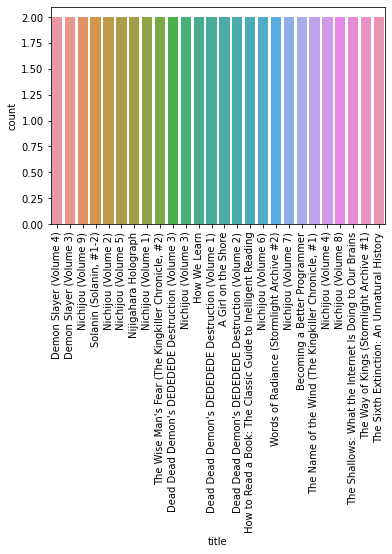

In [58]:
show_rereads(books)